# Examples

In [ ]:
# %matplotlib qt
import numpy as np
import glob
import solpolpy as sp
import matplotlib.pyplot as plt
import os
import matplotlib
import copy
import matplotlib.patches as pa
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

from astropy.io import fits
import astropy.units as u
from matplotlib.pyplot import figure
from sunpy.map.sources import LASCOMap
import sunpy.map

### Replace the paths here for your input and output

In [ ]:
path='/Volumes/Helios/polariz/indata' ## Input directory
out_path = '/Volumes/Helios/polariz/outdata/20230916/'		## Output directory
files = []

for f in glob.glob(path+'/*.fts'):
	files.append(f)
# out_data = load_data(files)

### Function to create a mask for occulter region

In [ ]:
def create_oculter_mask(file_path):
    f1 = fits.open(file_path)
    fimg = f1[0].data
    center_x = f1[0].header['CRPIX1']
    center_y = f1[0].header['CRPIX2']
    R_sun = 960. / f1[0].header['CDELT1']

    if f1[0].header['INSTRUME'] == 'LASCO':
        c = f1[0].header['DETECTOR']
        if 'C2' in c:
            R_i = 2.5
            colorm = plt.get_cmap('soholasco2')
        elif 'C3' in c:
            R_i = 4.0
            colorm = plt.get_cmap('soholasco3')
    elif f1[0].header['INSTRUME'] == 'COSMO K-Coronagraph':
        R_i = 1.15
        colorm = plt.get_cmap('kcor')
    elif f1[0].header['INSTRUME'] == 'SECCHI':
        c = f1[0].header['DETECTOR']
        if 'COR1' in c:
            R_i = 1.57
            colorm = plt.get_cmap('stereocor1')
        elif 'COR2' in c:
            R_i = 3.0
            colorm = plt.get_cmap('stereocor2')

    # Calibrate to solar radius
    x = np.empty(fimg.shape[0])
    y = np.empty(fimg.shape[1])
    for i in range(len(x)):
        x[i] = (i - center_x) / R_sun
        y[i] = (i - center_y) / R_sun

    n, m = fimg.shape
    rr = np.max(y) * R_sun
    xx, yy = np.ogrid[0:n, 0:m]
    msk = np.ones(fimg.shape)  # the final mask array
    mask = (xx - center_x) ** 2 + (yy - center_y) ** 2 < (R_i * R_sun) ** 2
    msk[mask] = 0
    mask = (xx - center_x) ** 2 + (yy - center_y) ** 2 > rr ** 2
    msk[mask] = 0

    return fimg, msk, colorm

### Function to display plots

In [60]:
def create_subplot(ax, data, meta, title, vmin, vmax, add_grid=False, add_colorbar=False):
    im = ax.imshow(data * msk, origin='lower', cmap=colorm, vmin=vmin, vmax=vmax)
    lon, lat = ax.coords
    lat.set_ticks(np.arange(-90, 90, 2) * u.degree)
    lon.set_ticks(np.arange(-180, 180, 2) * u.degree)
    lat.set_major_formatter('dd')
    lon.set_major_formatter('dd')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('HP Longitude', fontsize=fontsize)
    ax.set_ylabel('HP Latitude', fontsize=fontsize)
    ax.text(0, 0, meta['DATE-OBS'][0:16], color='white', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    
    if add_grid:
        ax.grid(color='white', ls='dotted')
    
    if add_colorbar:
        fig.colorbar(im, orientation='horizontal', ax=ax, shrink=0.9)


Creating a mask

In [ ]:
fimg, msk, colorm = create_oculter_mask(files[0])

# Plot the mask as an example
# plt.imshow(msk)
# plt.show()

### To resolve to any basis replace the 'out_polarize_state' from the list below in string format. The keyword to be used is given in paranthesis.
```
output = sp.resolve(outcube, out_polarize_state)
```

* MZP (MZP): Triplet of images taken at -60°, 0°, and +60° polarizing angles.

- B<sub>T</sub>, B<sub>R</sub> (BtBr): Pair of images with polarization along the tangential and radial direction with respect to the Sun respectively.

- Stokes (Stokes): Total (unpolarized) brightness (I), polarized brightness along vertical and horizontal axes (Q) and polarized brightness along ±45° (U) .

- B, pB (BpB): Total (unpolarized) brightness and ‘excess polarized’ brightness images pair respectively.

- B, pB, pB’ (Bp3): Analogous to Stokes I, Q and U, but rotates with α around the Sun unlike the later with fixed frame of reference of the instrument.

- B, θ, p (Bthp): System with total (unpolarized) brightness, angle and degree of polarization.

### Resolving to BpB pair

In [ ]:
outbpb = sp.resolve(files, 'BpB')

Knowing the keys are helpful to display the desired output

CAUTION: Change the keys in Display Output section from the current 'B' and 'pB' as required

In [ ]:
print, 'The cube keys are:'
outbpb.keys()

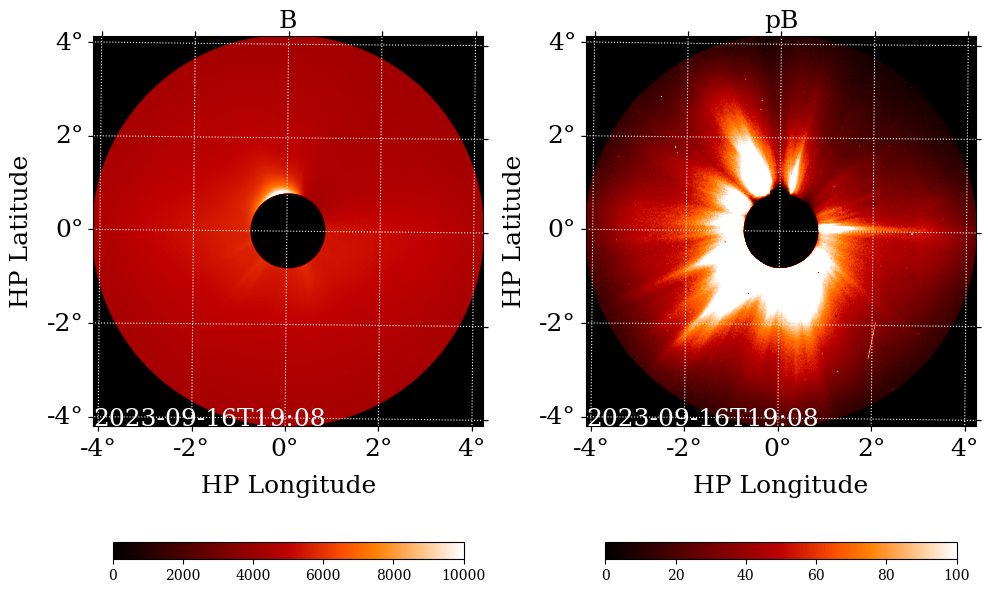

In [61]:
# Define parameters
wcs = outbpb['B'].wcs
colorm = plt.get_cmap('soholasco2')
fontsize = 18
fsz = 24

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 8), tight_layout=True, subplot_kw={'projection': wcs},sharey=True)

# Define data, metadata and titles for subplots
data_list = [outbpb['B'].data, outbpb['pB'].data]
meta_list = [outbpb['B'].meta, outbpb['pB'].meta]
titles = ['B', 'pB']
vmins = [0, 0]
vmaxs = [10000, 100]

# Create subplots using the create_subplot function
for i, ax in enumerate(axes):
    add_grid = True  # Change this to False if you don't want the grid
    add_colorbar = True  # Change this to False if you don't want the colorbar
    create_subplot(ax, data_list[i], meta_list[i], titles[i], vmins[i], vmaxs[i], add_grid, add_colorbar)

plt.show()

### To save output in FITS or PNG, uncomment the following cells

In [ ]:
###   To save the output in FITS
# hd = fits.PrimaryHDU(outbpb['B'].data, header=outcube['B'].meta)
# hd.writeto(out_path+out_file[0:16]+'B_base.fts',overwrite=True)

# hd = fits.PrimaryHDU(outbpb['pB'].data, header=outcube['pB'].meta)
# hd.writeto(out_path+out_file[0:16]+'pB_base.fts',overwrite=True)

In [ ]:
###   To save the output as png
# out_file = os.path.basename(files[0])
# fig.savefig(out_path+out_file[0:16]+'.png', dpi=300, bbox_inches='tight')

### Resolving BpB pair to Stokes

In [ ]:
outstokes = sp.resolve(outbpb, 'Stokes')

Knowing the keys are helpful to display the desired output

CAUTION: Change the keys in Display Output section from the current 'B' and 'pB' as required

In [ ]:
print, 'The cube keys are:'
outstokes.keys()

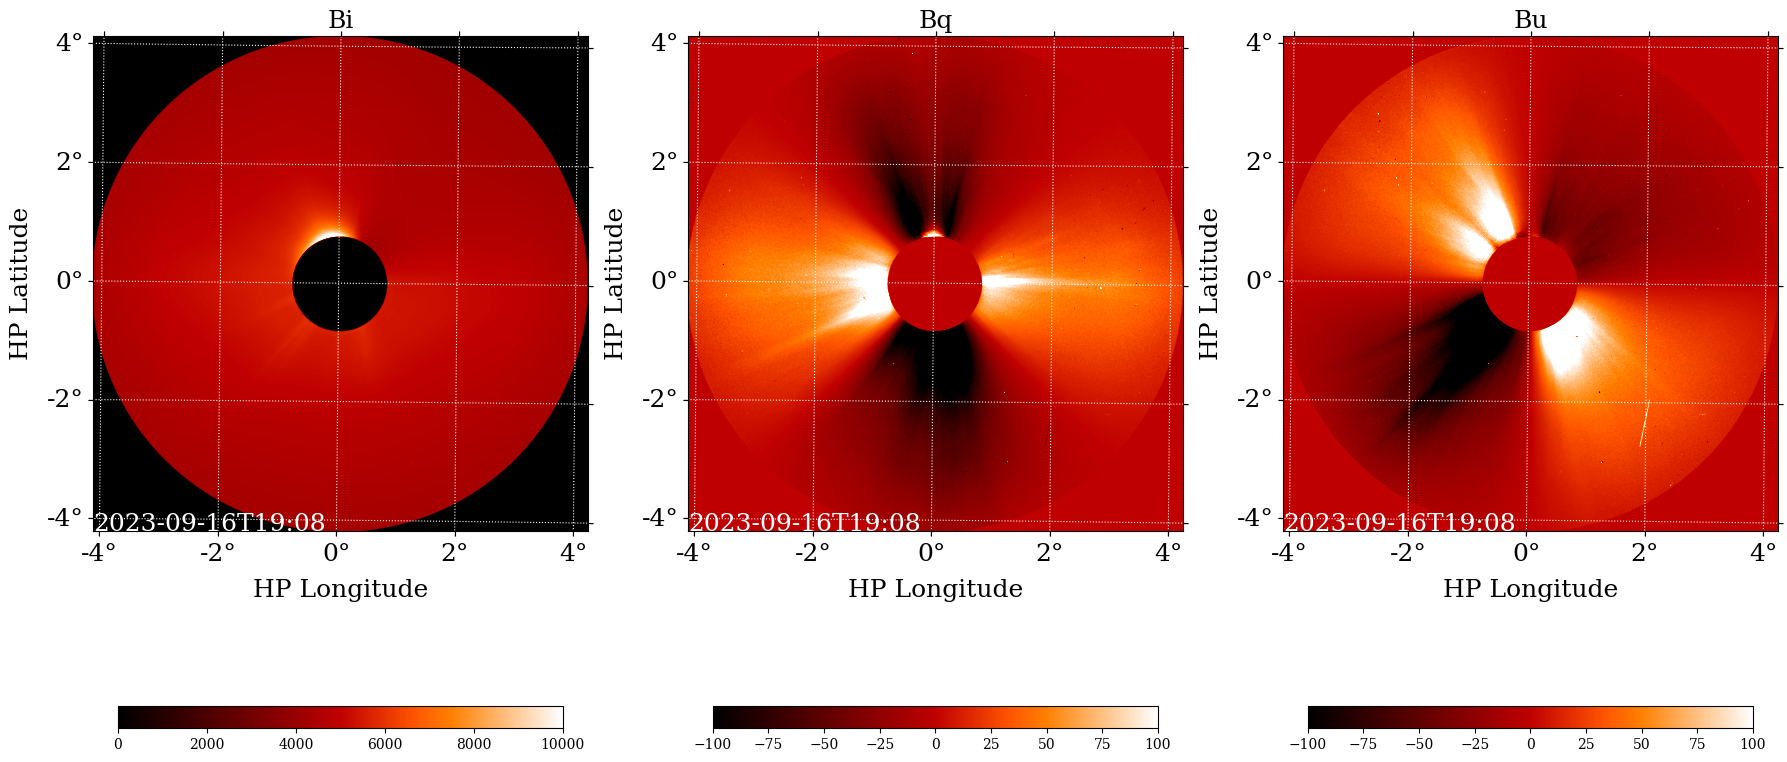

In [62]:
# Define parameters
wcs = outstokes['Bi'].wcs
colorm = plt.get_cmap('soholasco2')
fontsize = 18
fsz = 24

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 12), tight_layout=True, subplot_kw={'projection': wcs}, sharey=True)

# Define data and titles for subplots
data_list = [outstokes['Bi'].data, outstokes['Bq'].data, outstokes['Bu'].data]
meta_list = [outstokes['Bi'].meta, outstokes['Bq'].meta, outstokes['Bu'].meta]
titles = ['Bi', 'Bq', 'Bu']
vmins = [0, -100, -100]
vmaxs = [10000, 100, 100]

# Create subplots using the create_subplot function
for i, ax in enumerate(axes):
    add_grid = True  # Change this to False if you don't want the grid
    add_colorbar = True  # Change this to False if you don't want the colorbar
    create_subplot(ax, data_list[i], meta_list[i], titles[i], vmins[i], vmaxs[i], add_grid, add_colorbar)

plt.show()